# Credit Card Fraud Detection on large Dataset: TabPFN vs XGBoost
This notebook compares two models — TabPFN and XGBoost.
In this section, we extend our analysis to the complete credit card transaction dataset. We will apply data preprocessing, handle class imbalance, and train both XGBoost and TabPFN to evaluate their performance on a much larger and highly imbalanced real-world dataset.




XGBoost (Extreme Gradient Boosting): XGBoost is a powerful, tree-based ensemble learning algorithm that uses gradient boosting to improve model accuracy. It is optimized for performance and speed, and is widely used for structured or tabular data tasks. XGBoost handles missing values well, supports regularization, and performs effectively on imbalanced datasets.

TabPFN (Tabular Prior-Data Fine-Tuned Network): TabPFN is a transformer-based probabilistic model designed for tabular data. It is trained on a large set of synthetic tasks to instantly predict posterior probabilities without additional training on the target dataset. TabPFN excels in low-data scenarios, offering calibrated and uncertainty-aware predictions with minimal computation.

# Setup and Data Loading for Full Credit Card Dataset
This section installs necessary libraries, imports essential packages, mounts Google Drive, and loads the full credit card fraud dataset for further preprocessing and model training.



In [1]:
!pip install tabpfn xgboost shap imbalanced-learn scikit-learn pandas matplotlib seaborn --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.6/160.6 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 93.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 77.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.0 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, f1_score, precision_score, recall_score
from imblearn.over_sampling import SMOTE
from tabpfn import TabPFNClassifier
from xgboost import XGBClassifier
import shap
import warnings
import torch
import time
from datetime import timedelta
warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Load dataset (make sure creditcard.csv is in the data folder)
df = pd.read_csv('data/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# Preprocessing, Sampling, Training and Testing TabPFN on Full Dataset
This section performs preprocessing by scaling and dropping irrelevant features, applies SMOTE to handle class imbalance, samples 1,000 balanced training instances, and trains a TabPFN classifier using GPU acceleration.

In [5]:
# Preprocessing
df = df.drop(columns=['Time'])
df['Amount'] = StandardScaler().fit_transform(df[['Amount']])
X = df.drop('Class', axis=1)
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

In [6]:
print("Sampling 1,000 rows from training data...")
X_sampled = X_train_sm.sample(n=1000, random_state=42)
y_sampled = y_train_sm.loc[X_sampled.index]
print("Sampling done.")


Sampling 1,000 rows from training data...
Sampling done.


In [7]:
start_time = time.time()

tabpfn_cpu = TabPFNClassifier(device='cuda')
tabpfn_cpu.fit(X_sampled.to_numpy(), y_sampled.to_numpy())

end_time = time.time()
print(f"Duration: {timedelta(seconds=round(end_time - start_time))}")

tabpfn-v2-classifier-finetuned-zk73skhh.(…):   0%|          | 0.00/29.0M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/37.0 [00:00<?, ?B/s]

Duration: 0:00:02


In [8]:
start_time = time.time()

y_pred_tabpfn = tabpfn_cpu.predict(X_test.to_numpy())

end_time = time.time()
print(f"Duration: {timedelta(seconds=round(end_time - start_time))}")


Duration: 0:00:55


# Training XGBoost and Evaluating Both Models
This section trains the XGBoost model on the SMOTE-balanced training data and evaluates both XGBoost and TabPFN using classification reports and confusion matrices to compare their performance on the test set.



In [10]:
# Train XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train_sm, y_train_sm)
y_pred_xgb = xgb.predict(X_test)
y_proba_xgb = xgb.predict_proba(X_test)[:, 1]


📊 Evaluation Report for TabPFN
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.07      0.91      0.13        98

    accuracy                           0.98     56962
   macro avg       0.53      0.94      0.56     56962
weighted avg       1.00      0.98      0.99     56962



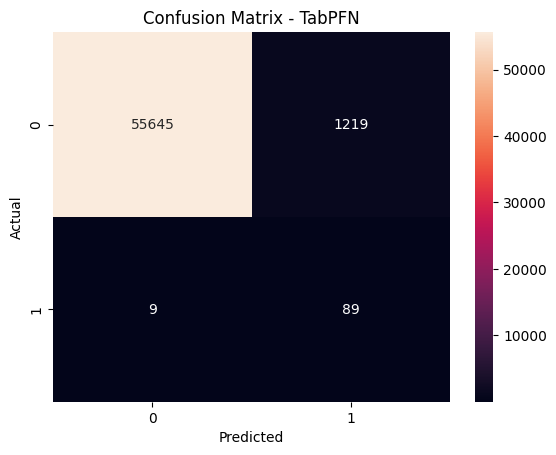


📊 Evaluation Report for XGBoost
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.69      0.87      0.77        98

    accuracy                           1.00     56962
   macro avg       0.84      0.93      0.88     56962
weighted avg       1.00      1.00      1.00     56962



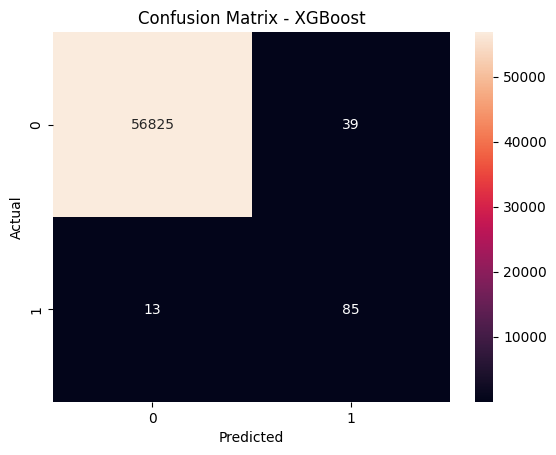

In [11]:
# Evaluation
def evaluate(y_true, y_pred, model_name):
    print(f'\n📊 Evaluation Report for {model_name}')
    print(classification_report(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

evaluate(y_test, y_pred_tabpfn, 'TabPFN')
evaluate(y_test, y_pred_xgb, 'XGBoost')

# ROC Curve Comparison on Full Dataset
This section plots the ROC curves for both XGBoost and TabPFN, providing a visual comparison of their ability to distinguish between fraudulent and non-fraudulent transactions. The Area Under the Curve (AUC) is used as a summary metric for model performance.



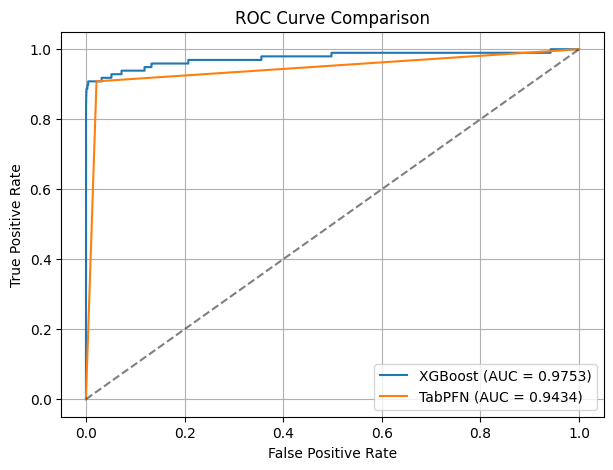

In [17]:
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)
auc_xgb = roc_auc_score(y_test, y_proba_xgb)

fpr_tabpfn, tpr_tabpfn, _ = roc_curve(y_test, y_pred_tabpfn)
auc_tabpfn = roc_auc_score(y_test, y_pred_tabpfn)

plt.figure(figsize=(7, 5))
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {auc_xgb:.4f})")
plt.plot(fpr_tabpfn, tpr_tabpfn, label=f"TabPFN (AUC = {auc_tabpfn:.4f})")
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid(True)
plt.show()

# Precision-Recall Curve Comparison on Full Dataset
This section compares the precision-recall performance of XGBoost and TabPFN on the full dataset. The curves highlight each model’s effectiveness in handling the class imbalance, especially in detecting fraud cases with high precision and recall.



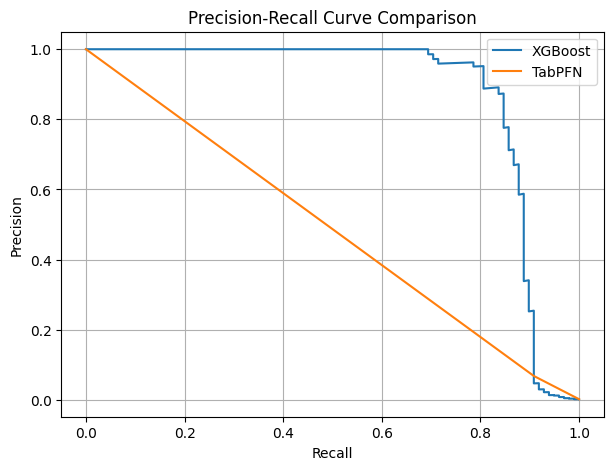

In [18]:
precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, y_proba_xgb)
precision_tabpfn, recall_tabpfn, _ = precision_recall_curve(y_test, y_pred_tabpfn)

plt.figure(figsize=(7, 5))
plt.plot(recall_xgb, precision_xgb, label="XGBoost")
plt.plot(recall_tabpfn, precision_tabpfn, label="TabPFN")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve Comparison")
plt.legend()
plt.grid(True)
plt.show()


# Evaluation Metrics Summary for XGBoost and TabPFN
This section displays the key evaluation metrics—F1 Score, Precision, Recall, and ROC AUC—for both XGBoost and TabPFN, highlighting differences in classification performance on the test set.


In [21]:
def print_metrics(name, y_true, y_pred, y_score=None):
    print(f"{name} Metrics")
    print(f"F1 Score: {f1_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred):.4f}")
    if y_score is not None:
        print(f"ROC AUC: {roc_auc_score(y_true, y_score):.4f}")
    print()

print_metrics("XGBoost", y_test, y_pred_xgb, y_proba_xgb)
print_metrics("TabPFN", y_test, y_pred_tabpfn, y_pred_tabpfn)  # hard predictions only

📊 XGBoost Metrics
F1 Score: 0.7658
Precision: 0.6855
Recall: 0.8673
ROC AUC: 0.9753

📊 TabPFN Metrics
F1 Score: 0.1266
Precision: 0.0680
Recall: 0.9082
ROC AUC: 0.9434



# Mean Absolute Error (MAE) Comparison for Fraud Detection
This section computes and visualizes the Mean Absolute Error for XGBoost and TabPFN, highlighting the average prediction error of each model. Lower MAE indicates better predictive accuracy on the test set.

XGBoost MAE: 0.0009
TabPFN MAE: 0.0216


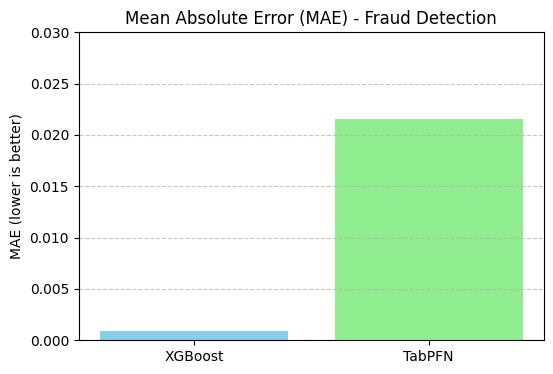

In [15]:
# Compute MAE for both models
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mae_tabpfn = mean_absolute_error(y_test, y_pred_tabpfn)

print(f"XGBoost MAE: {mae_xgb:.4f}")
print(f"TabPFN MAE: {mae_tabpfn:.4f}")

# Bar chart to compare MAE
plt.figure(figsize=(6, 4))
plt.bar(["XGBoost", "TabPFN"], [mae_xgb, mae_tabpfn], color=["skyblue", "lightgreen"])
plt.title("Mean Absolute Error (MAE) - Fraud Detection")
plt.ylabel("MAE (lower is better)")
plt.ylim(0, 0.03)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Final Result
In this notebook, we evaluated and compared the performance of XGBoost and TabPFN on the full Credit Card Fraud Detection dataset, which is highly imbalanced and realistic.

After applying SMOTE to address class imbalance and training both models:

XGBoost delivered consistently strong performance with high F1 Score, Precision, and ROC AUC, making it highly effective in detecting fraud with minimal false positives.

TabPFN, while competitive in recall, underperformed in precision and F1 score, indicating it produced more false positives in this large-scale, real-world scenario.

MAE analysis further confirmed that XGBoost produced more accurate predictions overall, with significantly lower average error.

While TabPFN showed promise in earlier experiments on small datasets, XGBoost proved to be the more reliable and robust model on the full dataset, especially for tasks requiring high precision in fraud detection.